# CMS Autoencoder Development

Joeri R. Hermans                    
*Departement of Data Science & Knowledge Engineering*          
*Maastricht University, The Netherlands*           

In this notebook we mainly deal with the development of an autoencoder of the CMS detector using the feature matrices that have been constructed in the previous notebooks.

## Cluster Configuration

In the following sections, we set up the cluster properties.

In [1]:
%matplotlib inline

import numpy as np

import os

from pyspark import SparkContext
from pyspark import SparkConf

from pyspark.sql.types import *

from pyspark.storagelevel import StorageLevel

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from distkeras.trainers import *
from distkeras.utils import *

from keras.optimizers import *
from keras.models import Sequential
from keras.layers.core import *
from keras.layers.convolutional import *
from keras.layers import *

# Use the DataBricks AVRO reader.
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-avro_2.11:3.2.0 pyspark-shell'

Using TensorFlow backend.


In [2]:
# Modify these variables according to your needs.
application_name = "CMS Autoencoder Development"
using_spark_2 = False
local = False

if local:
    # Tell master to use local resources.
    master = "local[*]"
    num_processes = 3
    num_executors = 1
else:
    # Tell master to use YARN.
    master = "yarn-client"
    num_executors = 20
    num_processes = 1

# This variable is derived from the number of cores and executors,
# and will be used to assign the number of model trainers.
num_workers = num_executors * num_processes

print("Number of desired executors: " + `num_executors`)
print("Number of desired processes / executor: " + `num_processes`)
print("Total number of workers: " + `num_workers`)

Number of desired executors: 20
Number of desired processes / executor: 1
Total number of workers: 20


In [3]:
# Do not change anything here.
conf = SparkConf()
conf.set("spark.app.name", application_name)
conf.set("spark.master", master)
conf.set("spark.executor.cores", `num_processes`)
conf.set("spark.executor.instances", `num_executors`)
conf.set("spark.executor.memory", "5g")
conf.set("spark.locality.wait", "0")
conf.set("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
conf.set("spark.kryoserializer.buffer.max", "2000")
conf.set("spark.executor.heartbeatInterval", "6000s")
conf.set("spark.network.timeout", "10000000s")
conf.set("spark.shuffle.spill", "true")
conf.set("spark.driver.memory", "10g")
conf.set("spark.driver.maxResultSize", "10g")

# Check if the user is running Spark 2.0 +
if using_spark_2:
    sc = SparkSession.builder.config(conf=conf) \
                     .appName(application_name) \
                     .getOrCreate()
else:
    # Create the Spark context.
    sc = SparkContext(conf=conf)
    # Add the missing imports
    from pyspark import SQLContext
    sqlContext = SQLContext(sc)

# Check if we are using Spark 2.0
if using_spark_2:
    reader = sc
else:
    reader = sqlContext

## Utility Functions

Some utility functions that will be processed used throughout this notebook.

In [4]:
def plot_matrix(m):
    plt.figure(figsize=(10,10), dpi=250)
    plt.imshow(m, cmap='plasma', interpolation='nearest')
    plt.show()

In [5]:
def conv_block(feat_maps_out, prev):
    prev = BatchNormalization(axis=1, mode=2)(prev) # Specifying the axis and mode allows for later merging
    prev = Activation('relu')(prev)
    prev = Convolution2D(feat_maps_out, 3, 3, border_mode='same')(prev) 
    prev = BatchNormalization(axis=1, mode=2)(prev) # Specifying the axis and mode allows for later merging
    prev = Activation('relu')(prev)
    prev = Convolution2D(feat_maps_out, 3, 3, border_mode='same')(prev) 
    
    return prev

In [6]:
def skip_block(feat_maps_in, feat_maps_out, prev):
    if feat_maps_in != feat_maps_out:
        # This adds in a 1x1 convolution on shortcuts that map between an uneven amount of channels
        prev = Convolution2D(feat_maps_out, 1, 1, border_mode='same')(prev)
        
    return prev 

In [7]:
def residual(feat_maps_in, feat_maps_out, prev_layer):
    skip = skip_block(feat_maps_in, feat_maps_out, prev_layer)
    conv = conv_block(feat_maps_out, prev_layer)

    return merge([skip, conv], mode='sum') # the residual connection

In [8]:
def plot_types_distribution(vector):
    fig, ax = plt.subplots()
    
    width = 5
    indexes = np.arange(11)
    ax.bar(indexes, vector, 1, color='b')
    ax.set_xlabel("Track types")
    ax.set_ylabel("Probability of occurance")
    ax.set_title("Distribution of track types in original dataset")
    ax.set_xticks(indexes)
    ax.set_xticklabels(indexes)

    fig.show()

In [9]:
def normalize_distribution(distribution):
    return np.divide(distribution, distribution.sum()).tolist()

## Data Loading and Preprocessing

Choose one of the following 3 datasets.

In [ ]:
# RAW FEATURE MATRICES
dataset = reader.read.format("com.databricks.spark.avro").load("data/collisions_feature_matrices.avro")

In [ ]:
# NORMALIZED FEATURE MATRICES
dataset = reader.read.format("com.databricks.spark.avro").load("data/collisions_feature_matrices_normalized.avro")

In [10]:
# BATCH-NORMALIZED FEATURE MATRICES
dataset = reader.read.format("com.databricks.spark.avro").load("data/collisions_feature_matrices_batch_normalized.avro")

In [11]:
# Read the collisions dataset to obtain meta-information about the tracks.
collisions = reader.read.format("com.databricks.spark.avro").load("data/collisions.avro")

In [12]:
def extract_track_types(iterator):
    for row in iterator:
        tracks = row['tracks']
        for t in tracks:
            yield t['track_type']

# Obtain the files from which we extracted the collisions.
files = collisions.mapPartitions(extract_track_types).distinct().collect()

In [13]:
files

[u'RelValSMS-T1tttt_mGl-1500_mLSP-100_13_nevents9000',
 u'RelValQQH1352T_13.nevents9000',
 u'RelValH125GGgluonfusion_13.nevents9000',
 u'RelValSMS-T1tttt_mGl-1500_mLSP-100_13_GEN-SIM-RECO_evt1750',
 u'RelValRSGravitonToGaGa_13_GEN-SIM-RECO_evt2000',
 u'RelValZpTT_1500_13_nevents9000',
 u'RelValPhiToMuMu_13_GEN-SIM-RECO_evt4358',
 u'RelValWjet_Pt_3000_3500_13_GEN-SIM-RECO_evt3150',
 u'RelValHiggs200ChargedTaus_13_nevents9000',
 u'RelValWjet_Pt_80_120_13.nevents9000',
 u'RelValDisplacedSUSY_stopToBottom_M_300_1000mm_13_GEN-SIM-RECO_evt3500',
 u'RelValH125GGgluonfusion_13_GEN-SIM-RECO_evt4500',
 u'RelValQCD_Pt_600_800_13_nevents9000',
 u'RelValRSKKGluon_m3000GeV_13_nevents9000']

In [14]:
# Construct the types from the files by removing the RelVal prefix and removing the suffix after the first _.
mapping = {}
types = []
index = 0
for f in files:
    if f not in mapping:
        type = f[6:f.find('_')]
        if type not in types:
            types.append(type)
            index += 1
        mapping[f] = types.index(type)

num_types = len(types)
mapping

{u'RelValDisplacedSUSY_stopToBottom_M_300_1000mm_13_GEN-SIM-RECO_evt3500': 8,
 u'RelValH125GGgluonfusion_13.nevents9000': 2,
 u'RelValH125GGgluonfusion_13_GEN-SIM-RECO_evt4500': 2,
 u'RelValHiggs200ChargedTaus_13_nevents9000': 7,
 u'RelValPhiToMuMu_13_GEN-SIM-RECO_evt4358': 5,
 u'RelValQCD_Pt_600_800_13_nevents9000': 9,
 u'RelValQQH1352T_13.nevents9000': 1,
 u'RelValRSGravitonToGaGa_13_GEN-SIM-RECO_evt2000': 3,
 u'RelValRSKKGluon_m3000GeV_13_nevents9000': 10,
 u'RelValSMS-T1tttt_mGl-1500_mLSP-100_13_GEN-SIM-RECO_evt1750': 0,
 u'RelValSMS-T1tttt_mGl-1500_mLSP-100_13_nevents9000': 0,
 u'RelValWjet_Pt_3000_3500_13_GEN-SIM-RECO_evt3150': 6,
 u'RelValWjet_Pt_80_120_13.nevents9000': 6,
 u'RelValZpTT_1500_13_nevents9000': 4}

In [15]:
def construct_output_vector(row):
    collision_id = row['id']
    tracks = row['tracks']
    files = []
    for t in tracks:
        file = t['track_type']
        if file not in files:
            files.append(file)
    # Construct the output vector.
    y = np.zeros(num_types)
    for f in files:
        y[mapping[f]] = 1.0
        
    return Row(**{'id': collision_id, 'y': y.tolist()})

# From this, construct a feature vector which represents the track types for every collision-id.
output_vectors = collisions.map(construct_output_vector).toDF()

In [16]:
def flatten(row):
    # Obtain the collision-id.
    collision_id = row['collision_id']
    # Obtain the feature matrices, and flatten them.
    m_f = np.asarray(row['front']).flatten()
    m_s = np.asarray(row['side']).flatten()
    
    return Row(**{'collision_id': collision_id, 'front': m_f.tolist(), 'side': m_s.tolist()})

training_set = dataset.map(flatten).toDF()
training_set = training_set.join(output_vectors, training_set.collision_id == output_vectors.id)
training_set = training_set.select("collision_id", "front", "side", "y")
training_set.persist(StorageLevel.MEMORY_AND_DISK)

training_set.printSchema()

print("Number of training samples: " + str(training_set.count()))

root
 |-- collision_id: string (nullable = true)
 |-- front: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- side: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- y: array (nullable = true)
 |    |-- element: double (containsNull = true)

Number of training samples: 22308


## Dataset Statistics

Before we start the training process, let us first gather some prior statistics on our dataset, i.e., what is the distribution of track types within our dataset.

/afs/cern.ch/user/j/jhermans/public/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


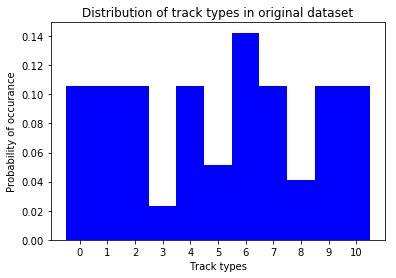

In [17]:
collision_distribution = np.asarray(training_set.select("y").rdd.reduce(lambda a, b: np.add(a, b).tolist())[0])
normalized_prior_distribution = np.divide(collision_distribution, collision_distribution.sum()).tolist()

plot_types_distribution(normalized_prior_distribution)

In [19]:
print("Number of occurences in " + str(types[3]) + ": " + str(collision_distribution[3]))

Number of occurences in RSGravitonToGaGa: 2000.0


From the histogram, we can see that some particular event types are definitly under-represented in the training set. To have a uniform distribution of track types, we need to sample the dataset in a particular way. However, since we are doing this in a multi-class classification context (predicting multiple classes at the same time), this is not very trival.

A first, but naive approach would be to sample all the RSGravitonToGaGa events, and plot the distribution, to check what exactly is happening. However, in this case, all you collisions would contain RSGravitionToGaGa tracks.

In [20]:
def fetch_data(iterator):
    for row in iterator:
        if row['y'][3] == 1:
            yield row

collision_distribution = training_set.select("y").mapPartitions(fetch_data)
collision_distribution = np.asarray(collision_distribution.reduce(lambda a, b: np.add(a, b).tolist())[0])

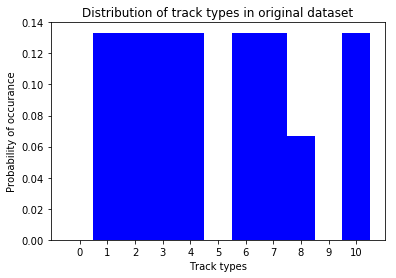

In [21]:
normalized_distribution = normalize_distribution(collision_distribution)
plot_types_distribution(normalized_distribution)

From this we observe that the follwing events do not occur in the presence of RSGravitonToGaGa events:

In [22]:
print(types[0])
print(types[5])
print(types[9])

SMS-T1tttt
PhiToMuMu
QCD


An alternative idea might be to select the samples which minimize the inbalance in the training set. A first approach would be to obtain an equal number of "different" vector types. Since we have 11 types, there are $2^{11} = 2048$ possible combinations of vectors. Let's first see how many we actually have.

In [23]:
print("Number of distinct collision vectors in training set: " + str(training_set.select("y").distinct().count()))

Number of distinct collision vectors in training set: 9


Which vectors?

In [24]:
training_set.select("y").distinct().collect()

[Row(y=[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
 Row(y=[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]),
 Row(y=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]),
 Row(y=[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0]),
 Row(y=[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0]),
 Row(y=[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]),
 Row(y=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]),
 Row(y=[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0]),
 Row(y=[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0])]

It might be interesting to know what is the distribution of these vectors are.

In [25]:
results = training_set.select("y").groupBy("y").count().collect()

results

[Row(y=[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], count=4358),
 Row(y=[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0], count=4449),
 Row(y=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0], count=5850),
 Row(y=[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0], count=1000),
 Row(y=[0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0], count=1000),
 Row(y=[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0], count=1),
 Row(y=[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0], count=3100),
 Row(y=[1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0], count=50),
 Row(y=[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0], count=2500)]

From this we know that collisions represented by [0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0] and [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0] do not happen very often in the datasets that have been handed to us. However, what we can see from this is that the training set it is actually rather balanced w.r.t. the vectors which occur in the training sets (with some exceptions).

## Model development

TODO Distributing training on full dataset.

Before constructing the autoencoder, we first need to obtain the dimensionality of our problem, i.e., the dimensionality of the feature matrices.

In [26]:
validation = training_set.sample(False, 0.001)
validation = validation.collect()
validation_x = [np.asarray(x['front']) for x in validation]
validation_y = [np.asarray(x['y']) for x in validation]
validation_x = np.asarray(validation_x)
validation_y = np.asarray(validation_y)

In [27]:
training = training_set.sample(False, 0.008)
training = training.collect()
training_x = [np.asarray(x['front']) for x in training]
training_y = [np.asarray(x['y']) for x in training]

training_x = np.asarray(training_x)
training_y = np.asarray(training_y)

input_size = training_x[0].shape[0]
output_size = input_size

In [44]:
# Simple MLP for development purposes.
mlp = Sequential()
mlp.add(Dense(5000, input_shape=(input_size,)))
mlp.add(Activation('relu'))
mlp.add(Dense(400))
mlp.add(Activation('relu'))
mlp.add(Dense(num_types))
mlp.add(Activation('sigmoid'))

In [45]:
mlp.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 5000)          386810000   dense_input_2[0][0]              
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 5000)          0           dense_4[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 400)           2000400     activation_4[0][0]               
____________________________________________________________________________________________________
activation_5 (Activation)        (None, 400)           0           dense_5[0][0]                    
___________________________________________________________________________________________

In [62]:
loss = 'kld'
optimizer = 'adam'

In [ ]:
mlp.compile(loss=loss, optimizer=optimizer, metrics=['mae', 'acc'])

In [ ]:
# Note, this model has been trained ~50 epochs before reaching this state.
# Of course, this is only trained on a small subset for development purposes.
mlp.fit(training_x, training_y, nb_epoch=10, verbose=1, batch_size=32)

Epoch 1/10
188/188 [==============================] - 57s - loss: 0.0089 - mean_absolute_error: 0.0905 - acc: 0.5319     
Epoch 2/10
188/188 [==============================] - 66s - loss: 2.1564e-04 - mean_absolute_error: 0.2729 - acc: 0.4574     

In [ ]:
Y = mlp.predict(validation_x)

In [ ]:
print("Expected: " + str(validation_y[0]))

In [ ]:
print("Predicted: \n" + str(Y[0]))